# Обучение модели классификации комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#импортируем необходимые библиотеки
import pandas as pd 
import lightgbm as lgb
import matplotlib.pyplot as plt 
import nltk
import numpy as np
import re
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier 

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/content/gdrive/MyDrive/toxic_comments.csv', index_col=0)

In [3]:
#изучим данные воспользовавшись унифицированной функцией
def uni_function(function):
    display(function.head())
    display(function.sample(n=3, random_state=12345))
    display(function.info())
    display(function.isna().mean().sort_values(ascending = False)) #доля пропущенных значений
    display(function.describe(include='all'))
    display(function.duplicated().sum())
    

In [4]:
display(uni_function(df))


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
109583,Expert Categorizers \n\nWhy is there no menti...,0
105077,"""\n\n Noise \n\nfart* talk. """,1
82244,"An indefinite block is appropriate, even for a...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

text     0.0
toxic    0.0
dtype: float64

,text,toxic
count,159292,159292.000000
unique,159292,NaN
top,Is the rupestris parent of AxR1 really St. Geo...,NaN
freq,1,NaN
mean,NaN,0.101612
std,NaN,0.302139
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


0

None

Данные чистые, мы можем приступить к дальнейшему анализу.

In [5]:
#определим уникальные значения в столбце toxic и определим их кол-во
display(df['toxic'].value_counts())

0    143106
1     16186
Name: toxic, dtype: int64

Как мы видим, в столбце присутсвует только два уникальных значения: ноль и единица. Нетоксичных комментариев заметно больше. Выясним, в каком соотношении.

In [6]:
comments = df['toxic'].value_counts()/df['toxic'].shape[0]*100
display(comments)


0    89.838787
1    10.161213
Name: toxic, dtype: float64

Токсичных комментариев совсем немного, всего 10%. Отразим это процентное соотношение на графике.

<AxesSubplot:xlabel='toxic', ylabel='Count'>

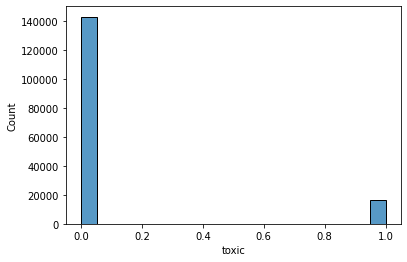

In [7]:
sns.histplot(data=df, x='toxic')

**Вывод**    
Мы произвели предобработку данных и познакомились с данными. Выяснили, что датасет чистый, не имеет пропусков и дубликатов,данные имеют соответствующие типы данных. Также мы выяснили, что у целевого признака присутствует несбалансированность. Разницы очевидна, всего 10% комментариев,от общего количества , является токсичными.    
Для дальнейшего анализа нам необходимо привести комментарии в должный вид: 
- приведем все комментарии к нижнему регистру;
- очистим текст от лишних символов
- проведем лемматизацию.

In [8]:
#приведем все буквенные данные к нижнему регистру
df['text'] = df['text'].str.lower()

In [9]:
#очистим текст от лишних символов
clear_comments = [] # создаём пустой список
pattern = r'[^a-zA-Z0-9]' #шаблон
for comments in df.text: # проходимся по каждому элементу исходного списка
  re_text = re.sub(pattern, ' ',comments)
  clear_comments.append(" ".join(re_text.split()))

In [10]:
df['clear_text'] = clear_comments
display(df.head())

,text,toxic,clear_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


In [11]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
# создайте мешок слов без учёта стоп-слов
count_vect = CountVectorizer()
bow = count_vect.fit_transform(df['clear_text']) 

print("Размер мешка без учёта стоп-слов:", bow.shape)

# создайте новый мешок слов с учётом стоп-слов
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))
count_vect = CountVectorizer(stop_words=stop_words)
bow = count_vect.fit_transform(df['clear_text']) 
print("Размер мешка с учётом стоп-слов:", bow.shape)

Размер мешка без учёта стоп-слов: (159292, 181867)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер мешка с учётом стоп-слов: (159292, 181722)


In [13]:
#Лемматизируем текст с помощью Wordnet из NLTK
lemmatizer = WordNetLemmatizer() #создадим экземпляр WordNetLemmatizer()

#создадим функцию, которая будет лемматизировать текст,учитывая все наши условия
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')

def lemmatize_text(text):
  lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text) if not w in stop_words])
  return lemmatized_output  


#nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger','omw-1.4')
df['text_lem'] = df['clear_text'].apply(lemmatize_text)
display(df.head())

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


,text,toxic,clear_text,text_lem
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edits make username hardcore metal...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,aww match background colour seemingly stuck th...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,hey man really try edit war guy constantly rem...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,make real suggestion improvement wonder sectio...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero chance remember page


## Обучение

### Определение выборок

In [14]:
#определим выборки
features = df.drop(['toxic', 'text', 'clear_text'], axis=1)
target = df['toxic'] # извлекаем целевой признак

In [15]:
#разделите данные на обучающую и тестовую выборки 
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.4, random_state = 12345, shuffle=False)
print(features_train.shape)
print(features_test.shape)

(95575, 1)
(63717, 1)


In [16]:
# создадим кросс-валидатор для последующего обучения моделей
cv = KFold(n_splits=3, shuffle=True, random_state=12345)


### LogisticRegression

In [17]:
#%%time


lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stop_words)),
    ('clf', LogisticRegression(random_state=12345))])

params = {'clf__C': [0.1, 1, 10, 100],
          'clf__class_weight': ['balanced', None]}

lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=params, cv=cv, scoring='f1', n_jobs=-1)
lr_grid.fit(features_train['text_lem'], target_train)
lr_best_paramms = lr_grid.best_params_
lr_best_score = lr_grid.best_score_
print(lr_best_paramms)
print(lr_best_score)

{'clf__C': 10, 'clf__class_weight': 'balanced'}
0.7683521519189513


После обучения мы получили значение метрики F1 = 0.768

### LGBMClassifier

In [18]:
#%%time
lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stop_words)),
    ('clf', LGBMClassifier(random_state=12345))])

params = {
  'clf__n_estimators': [200],
  'clf__learning_rate': [0.15, 0.25],
  'clf__max_depth': [8, 10, -1]}

lgb_grid = GridSearchCV(estimator=lgb_pipe, param_grid=params, cv=cv, scoring='f1', n_jobs=-1, refit=False)
lgb_grid.fit(features_train['text_lem'], target_train)
lgb_best_params = lgb_grid.best_params_
lgb_best_score = lgb_grid.best_score_
print(lgb_best_params)
print(lgb_best_score)

{'clf__learning_rate': 0.15, 'clf__max_depth': -1, 'clf__n_estimators': 200}
0.7604942935608303


После обучения мы получили значение метрики F1 = 0.761

Для удобства выполнения кода мы использовали Конструктор Pipeline от sklearn, который позволяет объединять преобразователи и оценщики в последовательность, которая функционирует как единое целое. Также, мы подобрали лучшие параметры для каждой модели используя GridSearchCV

### Проверка лучшей модели на тестовой выборке

In [19]:
test_pred = lr_grid.best_estimator_.predict(features_test['text_lem'])

test_f1 = f1_score(target_test, test_pred)   
print('F1 on test: {:.3f}'.format(test_f1)) 

F1 on test: 0.773


In [20]:
#сравнение результатов
#создадим сводную таблицу
best_result = pd.DataFrame([['LogisticRegression', lr_best_score, test_f1]],
                        columns = ['model', 'F1_train', 'F1_test'])
display(best_result)

,model,F1_train,F1_test
0,LogisticRegression,0.768352,0.773148


## Выводы

В ходе данной работы мы выполнили:

1. Предобработку данных. Выяснили, что данные чистые, пропусков и дубликатов нет, тип данных для каждого столбца соблюден. Аномалий не выявлено.
2. Исследовательский анализ данных. Рассчитали соотношение комментариев и определи, что нетоксичных комментариев значительно больше, примерно 90%.
3. Привели текст в нажлежащий вид. Привели его к нижнему регистру, очистили от лишних символов и провели лимматизацию.
4. Выделили обучающую и тестовую выборки в соотнощении 60/40.
5. Обучили две модели: LogisticRegression и LGBMClassifier, используя Конструктор Pipeline от sklearn и GridSearchCV.
6. Определи лучшую модель и проверили ее на тестовой выборке.    

Лучший результат на тестовой выборке у модели логистической регрессии. Метрика качества F1 составила 0.78. Данное значение удовлетворяет условиям нашей задачи.